In [121]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, mutual_info_classif, RFE
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Methods

In [86]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame
    
def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame
    
def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data.drop([target], axis=1)
    y = encode_variable(data_frame[target])
    return X, y 

# Load the data

In [64]:
data = pd.read_pickle("../data/final_sets/countries/model/2016_german")

In [65]:
data.head()

,gender,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,is_alive,distance_birth,distance_death,distance_delta,nationality_num,party_num,occupation_num,year_interval
7,male,2011,1.000,2.021104e-19,0,1,1,1652.0,70,no,142,71,71,1,0,1,3
113,male,2012,0.920,2.530002e-05,2,5,3,2376.0,73,no,128,54,74,1,0,1,3
127,male,2009,0.625,-1.456437e-19,0,4,4,32143.0,60,no,113,53,60,1,0,2,2
132,male,2009,1.000,9.096369e-08,1,2,1,2268.0,71,no,103,31,72,1,0,1,2
158,male,2011,0.750,7.461692e-04,2,4,2,19536.0,48,no,165,117,48,1,0,1,3


# Preprocesing

In [66]:
data = preprocess_data_frame(data, ["gender"])
# data["gender"]

['female', 'male']
{0, 1}


In [67]:
X,y=split_dataframe(data,"gender")

[0, 1]
{0, 1}


In [68]:
X.head()

,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,distance_birth,distance_death,distance_delta,nationality_num,party_num,occupation_num,is_alive_no,is_alive_unknown,is_alive_yes,year_interval_1,year_interval_2,year_interval_3
0,2011,1.000,2.021104e-19,0,1,1,1652.0,70,142,71,71,1,0,1,1,0,0,0,0,1
1,2012,0.920,2.530002e-05,2,5,3,2376.0,73,128,54,74,1,0,1,1,0,0,0,0,1
2,2009,0.625,-1.456437e-19,0,4,4,32143.0,60,113,53,60,1,0,2,1,0,0,0,1,0
3,2009,1.000,9.096369e-08,1,2,1,2268.0,71,103,31,72,1,0,1,1,0,0,0,1,0
4,2011,0.750,7.461692e-04,2,4,2,19536.0,48,165,117,48,1,0,1,1,0,0,0,0,1


In [69]:
y.head()

,gender
0,1
1,1
2,1
3,1
4,1


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_test = list(np.array(y_test.values).flatten())
y_train = list(np.array(y_train.values).flatten())

# No feature selection

In [71]:
model = tree.DecisionTreeClassifier()

In [72]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [73]:
p = model.predict(X_test, y_test)

In [74]:
accuracy_score(y_test, p)

0.7913486005089059

In [114]:
scores = cross_val_score(model, X_test, y_test, cv=10)
scores.var()

0.0022090610713348434

In [76]:
def plot_loged(data, col_name):
    x= np.log(data[col_name])
    x = x[~np.isnan(x)]
    x = x[x != np.inf]
    x = x[x != -np.inf]
    sns.distplot(x)

C:\Users\Latitude E7450\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


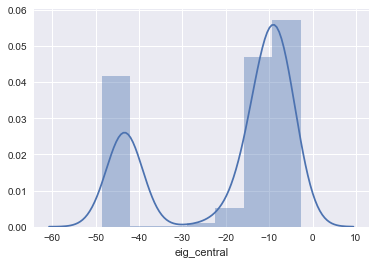

In [77]:
plot_loged(data, "eig_central")

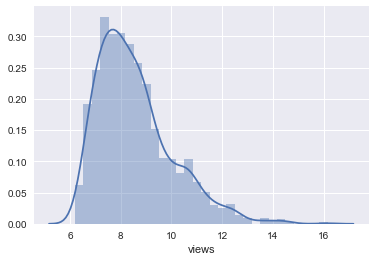

In [78]:
plot_loged(data, "views")

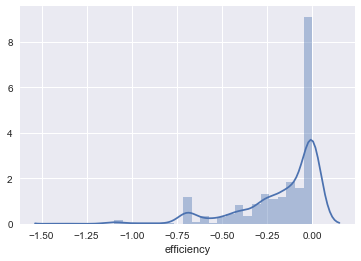

In [79]:
plot_loged(data, "efficiency")

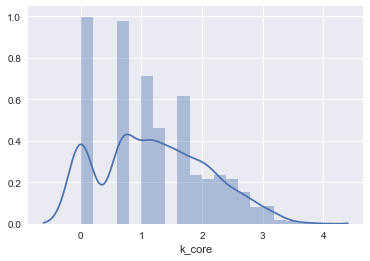

In [80]:
plot_loged(data, "k_core")

C:\Users\Latitude E7450\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


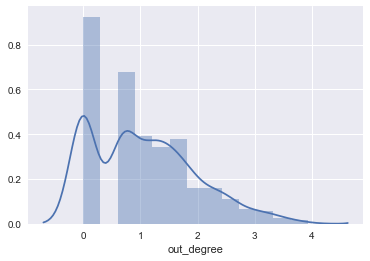

In [81]:
plot_loged(data, "out_degree")

C:\Users\Latitude E7450\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


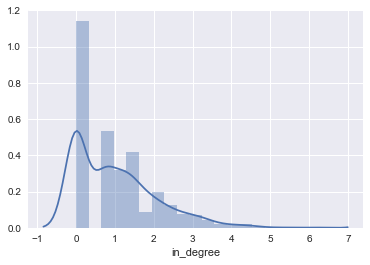

In [82]:
plot_loged(data, "in_degree")

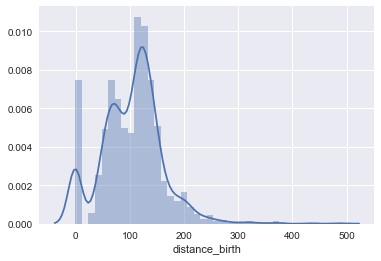

In [83]:
sns.distplot(data["distance_birth"])

# Feature Selection

In [84]:
show_kbest(data,"gender",linear_rel=True, k=10)

C:\Users\Latitude E7450\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


,F Score,P Value,Support,Attribute
0,23.908937,1.135522e-06,True,entered
1,0.598027,4.394718e-01,False,efficiency
2,0.413772,5.201741e-01,False,eig_central
3,0.348300,5.551794e-01,False,in_degree
4,0.639989,4.238605e-01,False,k_core
5,0.000055,9.940962e-01,False,out_degree
6,0.143939,7.044576e-01,False,views
7,0.075327,7.837766e-01,False,age
8,60.065530,1.834737e-14,True,distance_birth
9,73.230951,3.190713e-17,True,distance_death


In [87]:
show_kbest(data,"gender",linear_rel=False, k=10)

,Mutual Information,P Value,Support,Attribute
0,0.000000,None,False,entered
1,0.008780,None,True,efficiency
2,0.001628,None,False,eig_central
3,0.003309,None,False,in_degree
4,0.000000,None,False,k_core
5,0.008439,None,False,out_degree
6,0.000000,None,False,views
7,0.011173,None,True,age
8,0.059153,None,True,distance_birth
9,0.042509,None,True,distance_death


In [133]:
def change_of_accuracy_with_feature_selection(X,y,linear=True):
    score = []
    for k in range(len(X.columns),0,-1):
        df = show_kbest(data,"gender",linear_rel=linear, k=k)
        df = df[df["Support"] == True]
        columns = df["Attribute"].values
        X_ = X[columns]

        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)
        y_test = list(np.array(y_test.values).flatten())
        y_train = list(np.array(y_train.values).flatten())

        model = tree.DecisionTreeClassifier()
        model.fit(X_train, y_train)
        mean = cross_val_score(model, X_test, y_test, cv=10).mean()
        variance = cross_val_score(model, X_test, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])

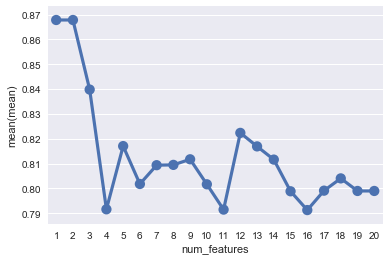

In [134]:
change_of_accuracy_with_feature_selection(X,y)

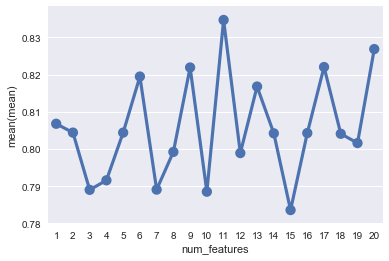

In [135]:
change_of_accuracy_with_feature_selection(X,y, linear=False)